In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tike
import xdesign as xd

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
NPIXEL = 1024
PIXEL_SIZE = 1/NPIXEL
TOTAL_TIME = 1.0
region = np.array([[-PIXEL_SIZE, PIXEL_SIZE], [-1, 1], [-1, 1]])/2
ideal_mean = TOTAL_TIME * PIXEL_SIZE
S_FREQ = 1/2**11


probe = tike.Probe(density_profile=None,
                   width=PIXEL_SIZE,
                   aspect=1.0,
                   lines_per_cm=NPIXEL)

def circle_density(x, y, radius=PIXEL_SIZE/2):
    """Return True for (x,y) contained by the circle with given radius"""
    return x**2 + y**2 <= radius**2

def get_mask(A):
    """Return a boolean mask for dimensions 1 & 2 of A"""
    assert A.shape[0] == A.shape[1]
    radius = A.shape[0] / 2.0
    coords = np.arange(A.shape[0]) - A.shape[0] / 2.0 + 0.5,
    x, y = np.meshgrid(coords, coords)
    mask = circle_density(x, y, radius=radius)
    return mask


def get_metric(coverage):
    """Return the standard deviation from the ideal coverage from the region
    inside the cylindrical mask
    """
    ideal_mean = TOTAL_TIME * PIXEL_SIZE
    if coverage.ndim > 3:
        coverage = np.linalg.eigvalsh(coverage)
    x = coverage[:, get_mask(coverage), :].flatten()
    metric = np.sqrt(np.sum((ideal_mean/2 - x)**2) / x.size) - np.mean(x)
    return metric

def fly2D(t, N=0):
    "The rotation as fast axis scanning pattern"
    h = t / TOTAL_TIME - 0.5
    v = 0 * t
    theta = np.pi/3 +  N * 2 * np.pi * t / TOTAL_TIME
    return theta, h, v

def raster2Dt(t, N=1):
    "The triangular scanning pattern"
    h = tike.triangle(0.5, N/2, np.pi/2, t)
    v = 0 * t
    theta = np.pi/3 + 2 * np.pi * t / TOTAL_TIME
    return theta, h, v

def raster2Ds(t, N=1):
    "The sinusoidal scanning pattern"
    h = tike.sinusoid(0.5, N/2, np.pi/2, t)
    v = 0 * t
    theta = np.pi/3 + 2 * np.pi * t / TOTAL_TIME
    return theta, h, v

def semifly(t, N=1):
    """The conventional scanning pattern"""
    h = tike.triangle(0.5, N/2, np.pi/2, t)
    v = 0 * t
    theta = np.pi/3 + tike.staircase(np.pi/N, N, 0, t)
    return theta, h, v

In [31]:
2**23

4194304

In [29]:
def generate_scanning_patterns(method, num_rotations=[NPIXEL]):
    """Generates scanning patterns for continuous scanning procedures
    
    Parameters
    method : string
        fly2D, raster2Dt, or raster2Ds
    
    """
    for R in num_rotations:
        kwargs = {'N' : R}
        tstep_guess = TOTAL_TIME / 2**23
        procedure = probe.procedure(trajectory=method,
                                    tmin=0, tmax=TOTAL_TIME, tstep=tstep_guess,
                                    tkwargs=kwargs)
        theta, h, v, dwell, time = procedure
        print(time.size)
        data = [theta, h]
        np.save('./data/scanning_patterns/{}_R{:03d}.npy'.format(method.__name__, R), data)

In [32]:
def generate_conventional_pattern():
    """Generates scanning patterns for discontinuous scanning procedures
    
    The conventional scanning pattern is discontinuous.  
    """
    R = NPIXEL
    kwargs = {'N' : R}
    tstep_guess = TOTAL_TIME / 2**23
    theta = np.array([])
    h = np.array([])
    v = np.array([])
    dwell = np.array([])
    for i in range(R):
        procedure = probe.procedure(trajectory=semifly,
                                  tmin=i/R*TOTAL_TIME, tmax=(i+1)/R*TOTAL_TIME, tstep=tstep_guess,
                                  tkwargs=kwargs)
        thetai, hi, vi, di, time = procedure
        theta = np.concatenate([theta, thetai])
        h = np.concatenate([h, hi])
        v = np.concatenate([v, vi])
        dwell = np.concatenate([dwell, di])
    # Get rid if points with no dwell time
    keep = dwell != 0
    theta = theta[keep]
    h = h[keep]
    v = v[keep]
    dwell = dwell[keep]
    assert theta.size == dwell.size
    data = [theta, h]
    np.save('./data/scanning_patterns/{}_R{:03d}.npy'.format('semifly', R), data)

In [30]:
for method in [fly2D, raster2Dt, raster2Ds]:
    generate_scanning_patterns(method)

INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,388,608 lines


8388608


INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,388,608 lines


8388608


INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,388,608 lines


8388608


In [ ]:
generate_conventional_pattern()

INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,231 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,230 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,232 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,229 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,231 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,231 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,231 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,228 lines
INFO:tik

INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,227 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,227 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,227 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,227 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,227 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,227 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,227 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,227 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tik

INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tik

INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,226 lines
INFO:tik

INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tik

INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tik

INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tik

INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,225 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tik

INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tik

INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tik

INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tik

INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tik

INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tik

INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tik

INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tike.probe: procedure is 8,224 lines
INFO:tike.probe: line_width is 0.000976562 cm
INFO:tike.probe: probe uses 1 lines
INFO:tik

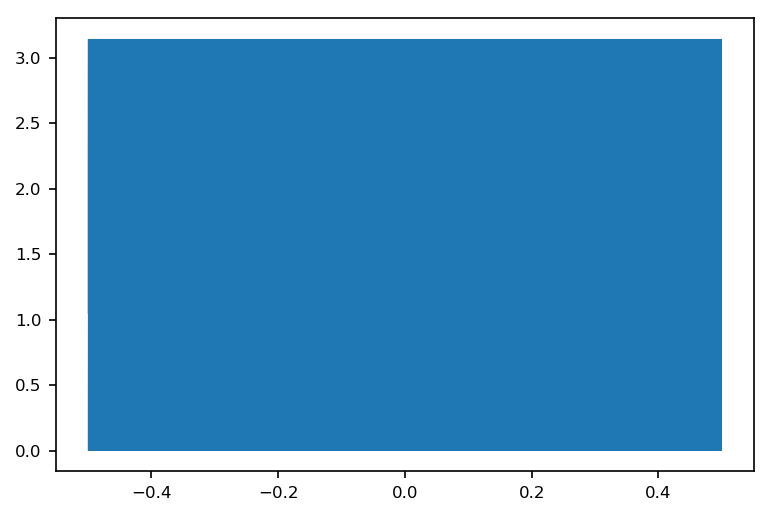

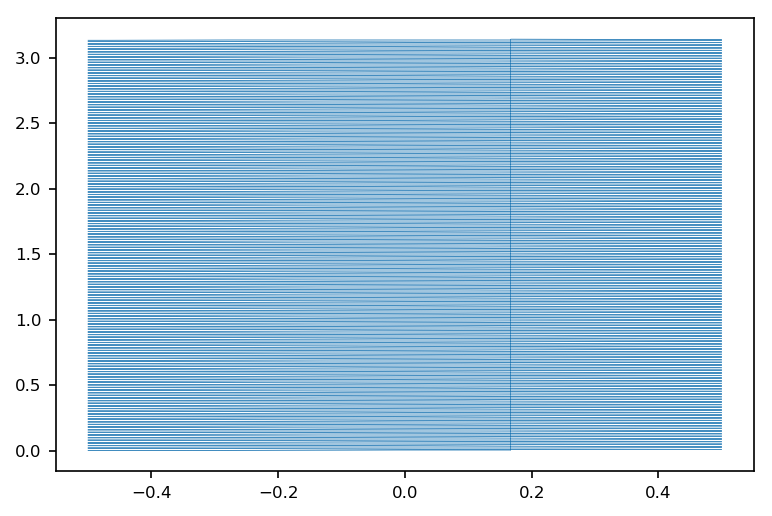

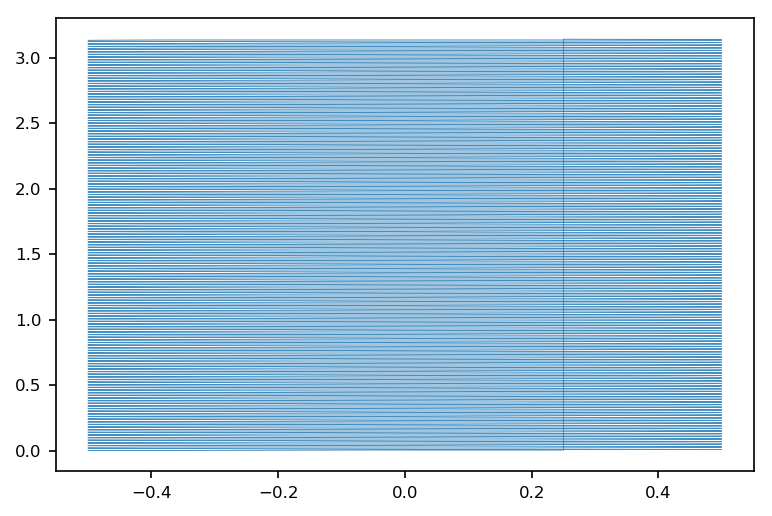

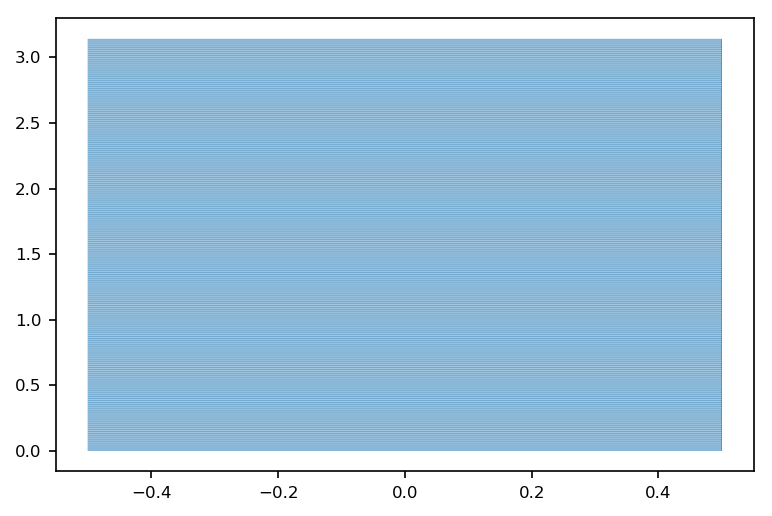

In [11]:
for method in [fly2D, raster2Dt, raster2Ds, semifly]:
    theta, h = np.load('./data/scanning_patterns/{}_R{:03d}.npy'.format(method.__name__, NPIXEL))
    plt.figure(dpi=150)
    plt.plot(h, theta % np.pi, linewidth=0.1)
    plt.show()